<a href="https://colab.research.google.com/github/Ankur-singh/UnderstandingLLMs/blob/main/nbs/LLM_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

To create a minimal GPT-style model, the following core components are required:

* **Model Architecture**: The neural network design that defines how tokens are processed and how contextual relationships are modeled.
* **Inference (Next Token Generation)**: The mechanism that uses the trained model to generate the next token based on input tokens.
* **Data for Training**: A dataset of tokenized text used to train the model.
* **Training Loop**: The process that iteratively updates the model's parameters to minimize prediction error.

Each component will be implemented in the simplest form to ensure clarity of how they function individually and as a complete system. Later notebooks will build upon this foundation, introducing improvements and optimizations to each part.

In [12]:
!pip install -Uq torch
!pip install -Uq datasets tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Misc
import math
import tiktoken
from tqdm.notebook import tqdm
from datasets import load_dataset
from dataclasses import dataclass
from prettytable import PrettyTable

# Model Architecture

We will start by first defining the model architecture and try to generate some text to make sure everything is working as expected

In [2]:
class MultiheadAttention(nn.Module):
    def __init__(self, emb_dim, heads, context):
        super().__init__()
        assert emb_dim % heads == 0, "`emb_dim` should be a multiple of `heads`"
        self.context = context
        self.mha = nn.MultiheadAttention(emb_dim, heads, batch_first=True)
        self.proj = nn.Linear(emb_dim, emb_dim)
        self.register_buffer("mask", torch.triu(torch.ones(context, context), diagonal=1).bool())

    def forward(self, x):
        batch, seq_len, _ = x.shape
        seq_len = min(seq_len, self.context)
        attn_mask = self.mask[:seq_len, :seq_len]
        attn_out, _ = self.mha(x,x,x,attn_mask=attn_mask, need_weights=False)
        return self.proj(attn_out)

class Block(nn.Module):
    def __init__(self, emb_dim, heads, context):
        super().__init__()
        self.mha = MultiheadAttention(emb_dim, heads, context)
        self.mlp = nn.Sequential(
                        nn.Linear(emb_dim, 4 * emb_dim),
                        nn.GELU(),
                        nn.Linear(4 * emb_dim, emb_dim)
                    )
        self.sa_norm = nn.LayerNorm(emb_dim)
        self.mlp_norm = nn.LayerNorm(emb_dim)

    def forward(self, x):
        x = x + self.mha(self.sa_norm(x))
        x = x + self.mlp(self.mlp_norm(x))
        return x

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.pos_embedding = nn.Embedding(config.context, config.emb_dim)
        self.tok_embedding = nn.Embedding(config.vocab, config.emb_dim)
        self.decoder = nn.Sequential(*[Block(config.emb_dim, config.heads, config.context)
                                        for _ in range(config.layers)])
        self.output = nn.Linear(config.emb_dim, config.vocab, bias=False)
        self.norm = nn.LayerNorm(config.emb_dim)

    def forward(self, x):
        batch, seq_len = x.shape
        pos = torch.arange(seq_len, device=x.device)
        x = self.tok_embedding(x) + self.pos_embedding(pos)
        x = self.decoder(x)
        return self.output(self.norm(x))

    @property
    def device(self):
        return next(self.parameters()).device

In [3]:
@dataclass
class ModelConfig:
    # GPT2 architecture
    vocab: int   = math.ceil(50_257 / 64) * 64 # nearest multiple of 64
    emb_dim: int = 768
    heads: int   = 12
    layers: int  = 12
    context: int = 1024

device = "cuda" if torch.cuda.is_available() else "cpu"
model = GPT(ModelConfig)
model = model.to(device)

In [4]:
# Utility Function: Number of Trainable Parameters
def count_parameters(model, verbose=False):
    if verbose:
        table = PrettyTable(["Module", "Parameters"])
        total = 0
        for name, param in model.named_parameters():
            if param.requires_grad:
                count = param.numel()
                table.add_row([name, count])
                total += count
        print(table)
    else:
        total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Trainable Params: {total / 1e6:.2f} M")

count_parameters(model)

Total Trainable Params: 170.20 M


Based on my calculations, this looks good.

> **Note:** This is not exactly save as GPT2 (124M). That is because of **no weight-tying** and other small difference. Read [this](https://www.perplexity.ai/search/weight-tying-gpt2-bgeVq5MzTbC2v8d5NEFx_g) for details.    

# Inference (Next Token Generation)

In [5]:
tokenizer = tiktoken.get_encoding("gpt2")

In [6]:
@torch.no_grad()
def generate(model, tokenizer, prefix, max_new_tokens=10):
    model.eval()
    token_ids = torch.tensor(tokenizer.encode(prefix), device=device).unsqueeze(0)
    for _ in range(max_new_tokens):
        logits = model(token_ids)
        logits = logits[:, -1, :]
        next_idx = torch.argmax(logits, dim=-1, keepdim=True)
        prefix += tokenizer.decode([next_idx.cpu()])
        token_ids = torch.cat((token_ids, next_idx), dim=1)
    return prefix

prefix = "Once upon a time"
print(generate(model, tokenizer, prefix))

Once upon a timeosexual arguably weakness compan commander abolish Layer cornerstone 445 Dharma


The generated text is all gibrish are the model is not trained yet.

> **Note:** We will keep getting the same output if we run the above cell multiple times, as there is no randomness in sampling process. We initialize the model with random weights and that is it. So, we must reinitialize our model to get different output.

# Data

In [ ]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [ ]:
val_ds = "\n\n".join(dataset["test"]["text"])
train_ds = "\n\n".join(dataset["train"]["text"])

val_tokens = tokenizer.encode(val_ds)
train_tokens = tokenizer.encode(train_ds)
len(val_tokens), len(train_tokens)

(287644, 2428601)

In [ ]:
class WikiTextDataset(Dataset):
    def __init__(self, tokens, max_len):
        self.tokens = tokens
        self.max_len = max_len

    def __getitem__(self, idx):
        idx = idx * self.max_len
        x = self.tokens[idx: idx + self.max_len]
        y = self.tokens[idx+1: idx+1 + self.max_len]
        if len(x) < self.max_len:
            x = x + [tokenizer.eot_token] * (self.max_len - len(x))
        if len(y) < self.max_len:
            y = y + [tokenizer.eot_token] * (self.max_len - len(y))
        return (torch.tensor(x),torch.tensor(y))

    def __len__(self):
        return math.ceil(len(self.tokens)/self.max_len)

val_ds = WikiTextDataset(val_tokens, ModelConfig.context)
train_ds = WikiTextDataset(train_tokens, ModelConfig.context)
len(val_ds), len(train_ds)

(281, 2372)

In [ ]:
batch_size = 6
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
next(iter(val_dl))

[tensor([[  628,   796,  5199,  ...,   290, 43823, 24265],
         [ 7924,   416,   440,  ...,   272,   764,   679],
         [ 4054,   837,   284,  ...,   262,  3931,   286],
         [  767,  3365,   339,  ...,    84, 28599,   764],
         [ 1881,   286,   262,  ...,  2630,   257,  3704],
         [11749, 10343, 13333,  ...,   406,   131,   250]]),
 tensor([[  796,  5199,   347,  ..., 43823, 24265,  7924],
         [  416,   440, 12810,  ...,   764,   679,  4054],
         [  837,   284,   465,  ...,  3931,   286,   767],
         [ 3365,   339,   373,  ..., 28599,   764,  1881],
         [  286,   262, 14555,  ...,   257,  3704, 11749],
         [10343, 13333,   290,  ...,   131,   250, 44019]])]

# Training Loop

In [ ]:
@torch.no_grad()
def evaluate(model, dl):
    model.eval()
    loss = 0
    for (x,y) in dl:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss += F.cross_entropy(logits.flatten(0, 1), y.flatten()).cpu().item()
    model.train()
    return loss / len(dl)

In [ ]:
model.to(device)
evaluate(model, val_dl)

11.029688192450482

This looks right, initially the probability will be evenly distributed i.e. each token will roughly have the same probability. As result, we can calculated the expected value of loss `-ln(1/50304) ~= 10.826`

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
log_freq = 40
epochs = 2
losses = []

for epoch in range(epochs):
    for i, (x,y) in enumerate(pbar := tqdm(train_dl, desc="Training")):
        if i % log_freq == 0:
            val_loss = evaluate(model, val_dl)
            losses.append(val_loss)
            pbar.set_postfix_str(f"[Epoch {epoch}] Val Loss: {val_loss:.3f}")
            torch.save(model.state_dict(), "model.pth")
            print("="*20)
            print(generate(model, tokenizer, prefix))

        model.train()
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits.flatten(0,1), y.flatten())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Training:   0%|          | 0/395 [00:00<?, ?it/s]

Once upon a time , and the first time , and the first to
Once upon a time , and the first time , and the first time
Once upon a time . 


 = = = = = =
Once upon a time , and the first time , and the first time
Once upon a time , and the first time . The first time ,
Once upon a time . 


 = = = = = =
Once upon a time . 


 = = = = = =
Once upon a time . 


 = = = = = 
Once upon a time in the first time . 


 = =
Once upon a time in the first time . 


 = =


Training:   0%|          | 0/395 [00:00<?, ?it/s]

Once upon a time of the first time of the United States . The
Once upon a time of the first time . The first time , the
Once upon a time of the first time of the United States . 
Once upon a time of the first time , the United States , the
Once upon a time of the first time . The first time of the
Once upon a time in the first game . 


 The first


KeyboardInterrupt: 

# Inference

Lets load the saved model and try to generate some sample text . . .

In [7]:
state_dict = torch.load("model.pth", map_location=device, weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
print(generate(model, tokenizer, "Once upon a time"))

Once upon a time of the first time . The first time of the


In [9]:
print(generate(model, tokenizer, "Internet is an"))

Internet is an important . 


 The first time , and


In [10]:
print(generate(model, tokenizer, "AI will"))

AI will be a new of the first time of the first


In [11]:
print(generate(model, tokenizer, "The meaning of life is"))

The meaning of life is a large @-@ century . The first time


From the output, its obvious that the generations are not very good. Time to introduce some randomness.

Instead of using the largest probability everytime, we can sample the next token index from a distribution where the chance of drawing a index is directly proportional to its probility. Here we will need two steps:
1. Turn `logits` in to probabilities
2. Draw next token index from a distribution based on above probabilities.

**Note**: An added benefit of drawing from a distributions is randomness . Everytime you run the cell, you will see different output text generated.

In [12]:
@torch.no_grad()
def generate(model, tokenizer, prefix, max_new_tokens=10):
    model.eval()
    token_ids = torch.tensor(tokenizer.encode(prefix), device=device).unsqueeze(0)
    for _ in range(max_new_tokens):
        logits = model(token_ids)
        logits = logits[:, -1, :]
        probs = torch.softmax(logits, dim=-1)  # <-- update
        next_idx = torch.multinomial(probs, num_samples=1) # <-- update
        prefix += tokenizer.decode([next_idx])
        token_ids = torch.cat((token_ids, next_idx), dim=1)
    return prefix

In [19]:
print(generate(model, tokenizer, "Once upon a time"))

Once upon a time used location amusement sevent Charles Bis chaired ap called


In [20]:
print(generate(model, tokenizer, "Internet is an"))

Internet is an flawed to them into a minimum . Some symptoms recommendations


In [21]:
print(generate(model, tokenizer, "AI will"))

AI will pull . In 16 May 21 , dominated to oppose


In [22]:
print(generate(model, tokenizer, "The meaning of life is"))

The meaning of life is Prague ) . On from Dting daily him ,


Another good to have *nobe* is `temperature`. This controls how pointy the softmax input are.

In [23]:
@torch.no_grad()
def generate(model, tokenizer, prefix, max_new_tokens=10, temp=1.0):
    model.eval()
    token_ids = torch.tensor(tokenizer.encode(prefix), device=device).unsqueeze(0)
    for _ in range(max_new_tokens):
        logits = model(token_ids)
        logits = logits[:, -1, :]
        probs = torch.softmax(logits / temp, dim=-1)  # <-- update: scale using temp
        next_idx = torch.multinomial(probs, num_samples=1)
        prefix += tokenizer.decode([next_idx])
        token_ids = torch.cat((token_ids, next_idx), dim=1)
    return prefix

Heres the rational behind `temperature` and how its related to creativity

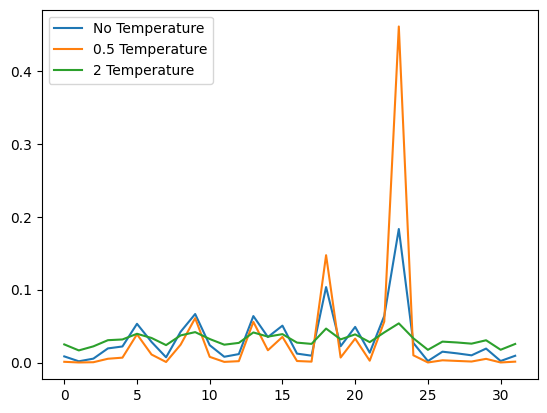

In [30]:
import matplotlib.pyplot as plt

logits = torch.randn(4, 32)
plt.plot(torch.softmax(logits[0], dim=-1)      , label="No Temperature")
plt.plot(torch.softmax(logits[0] / 0.5, dim=-1), label="0.5 Temperature")
plt.plot(torch.softmax(logits[0] / 4 , dim=-1) , label="2 Temperature")
plt.legend()

As you can see,
- If `temperature` is small (i.e < 1) (say ~0.5) then the logits values become large and softmax output is pointy. Hence we will only have a few tokens with very high probability.
- If `temperature` is large (i.e., > 1) then logit values become small and softmax output is quite evenly distributed. As a result, the we will have multiple small peaks indicating numerous choice of next tokens.

Yet another improvement is to only use top-k probabilities when choosing the next token

In [ ]:
def topk(logits, k=5):
    topk_vals, topk_idxs = torch.topk(logits, k)
    probs = torch.zeros_like(logits)
    probs[:, topk_idxs] = torch.softmax(topk_vals, dim=-1)
    return probs

@torch.no_grad()
def generate(model, tokenizer, prefix, max_new_tokens=10, temp=1.0):
    model.eval()
    token_ids = torch.tensor(tokenizer.encode(prefix), device=device).unsqueeze(0)
    for _ in range(max_new_tokens):
        logits = model(token_ids)
        logits = logits[:, -1, :]
        probs = topk(logits / temp)  # <-- update: only `topk` probabilities
        next_idx = torch.multinomial(probs, num_samples=1)
        prefix += tokenizer.decode([next_idx])
        token_ids = torch.cat((token_ids, next_idx), dim=1)
    return prefix

### Questions

1. Study `softmax`. When to use `0` or `-inf` to mask tokens.
    - Can not use `0`, that is only for the probs that we get after softmax operation. That way, we only have to calculate the softmax for topk values.
    - Use `-inf` to make the `probs` zeros for that token/value.

2. Which approach is accurate and faster: applying softmax to only topk values or all the value after setting the non-topk values to `0`
    - Therotically, the softmax is a compute heavy operation. So apply it only on topk values should be faster. Unless, pytorch does some optimization to ignore the `-inf` values.